In [9]:
import pandas as pd
import numpy as np
import ast
import csv
import seaborn as sns
import matplotlib.pyplot as plt



In [10]:


input_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/Softdis_atlas_alphafold_trizod/final_final_filtered_dataset.csv"
output_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_long_format.csv"
norm_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_long_norm.csv"
wide_format_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_wide_format.csv"


In [11]:

def safe_literal_eval(x):
    try:
        if isinstance(x, str):
            x = x.strip()
            if x.startswith("[") and x.endswith("]"):
                values = ast.literal_eval(x)
                
                return [np.nan if v is None else float(v) for v in values]
        return x
    except Exception:
        return []


In [12]:


with open(output_path, mode='w', newline='') as f_out:
    writer = csv.DictWriter(f_out, fieldnames=["pdb_id", "uniprot_id", "residue_index", "source", "value"])
    writer.writeheader()

    
    chunksize = 500  # 500 lines each read
    for chunk in pd.read_csv(input_path, chunksize=chunksize, low_memory=False):
        chunk["values"] = chunk["values"].apply(safe_literal_eval)

        for _, row in chunk.iterrows():
            pdb_id = row["pdb_id"]
            uniprot_id = row["uniprot_id"]
            source = row["sources"]
            try:
                
                if pd.isna(row["SP_BEG"]):
                    print(f"⚠️ Skipping row: SP_BEG is NaN for pdb_id {pdb_id}")
                    continue
                    
                sp_beg = int(row["SP_BEG"])
                values = row["values"]
                for i, val in enumerate(values):
                    residue_index = sp_beg + i
                    writer.writerow({
                        "pdb_id": pdb_id,
                        "uniprot_id": uniprot_id,
                        "residue_index": residue_index,
                        "source": source,
                        "value": float(val)  
                    })
            except Exception as e:
                print(f"⚠️ Skipping row due to error: {e}")

print("✅ Done: Converted to long format and saved as 'residue_level_long_format.csv'")


⚠️ Skipping row: SP_BEG is NaN for pdb_id 12e8_h
⚠️ Skipping row: SP_BEG is NaN for pdb_id 12e8_l
⚠️ Skipping row: SP_BEG is NaN for pdb_id 12e8_m
⚠️ Skipping row: SP_BEG is NaN for pdb_id 12e8_p
⚠️ Skipping row: SP_BEG is NaN for pdb_id 148l_s
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a07_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a07_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a08_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a08_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a09_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a09_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1a_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1a_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1b_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1b_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1c_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1c_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1e_c
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1e_d
⚠️ Skipping row: SP_BEG is NaN for pdb_id 1a1m_c
⚠️ Skipping row: SP_

In [13]:
df = pd.read_csv(output_path)
df

/var/folders/b7/_3x72hqs41x0p2_00qb8lf9m0000gn/T/ipykernel_78315/4027011927.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_path)


,pdb_id,uniprot_id,residue_index,source,value
0,102l_a,P00720,1,bfactors,22.030000
1,102l_a,P00720,2,bfactors,11.260000
2,102l_a,P00720,3,bfactors,10.410000
3,102l_a,P00720,4,bfactors,7.520000
4,102l_a,P00720,5,bfactors,10.640000
...,...,...,...,...,...
26891762,8htw_b,Q7LYJ6,177,RMSF,0.083333
26891763,8htw_b,Q7LYJ6,178,RMSF,0.114000
26891764,8htw_b,Q7LYJ6,179,RMSF,0.167667
26891765,8htw_b,Q7LYJ6,180,RMSF,0.285667


In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm

input_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_long_format.csv"
output_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_zscore_streamed.csv"


df_long = pd.read_csv(input_path, dtype={'pdb_id': str, 'uniprot_id': str, 'residue_index': int, 'source': str, 'value': float})


groups = df_long.groupby(["pdb_id", "source"])

# initialize the output file
first = True

print("⏳ Start streaming z-score normalization to CSV...")
for (pdb_id, source), group in tqdm(groups, total=len(groups)):
    if group["value"].std() != 0 and not group["value"].isnull().all():
        group["value_norm"] = (group["value"] - group["value"].mean()) / group["value"].std()
    else:
        group["value_norm"] = 0.0

    # each group append to the output file
    group.to_csv(output_path, mode='w' if first else 'a', index=False, header=first)
    first = False  # no header after the first group

print(f"✅ Done! Output saved to: {output_path}")


⏳ Start streaming z-score normalization to CSV...


100%|█████████▉| 107792/107793 [01:28<00:00, 1221.83it/s]

✅ Done! Output saved to: /Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_zscore_streamed.csv


In [15]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

input_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_zscore_streamed.csv"
output_path = "/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_wide_format.csv"

# temporary dictionary: each residue value
data_dict = defaultdict(dict)

# read a small chunk each time
chunk_size = 100000
reader = pd.read_csv(input_path, chunksize=chunk_size)

for chunk in tqdm(reader, desc="Reading long-format in chunks"):
    for _, row in chunk.iterrows():
        key = (row["pdb_id"], row["uniprot_id"], row["residue_index"])
        source = row["source"].lower()  # 转小写统一列名（如 plDDT -> plddt）
        data_dict[key][source] = row["value_norm"]

# re-organize to DataFrame
rows = []
for (pdb_id, uniprot_id, res_idx), source_dict in data_dict.items():
    row = {
        "pdb_id": pdb_id,
        "uniprot_id": uniprot_id,
        "residue_index": res_idx,
    }
    row.update(source_dict)
    rows.append(row)

df_wide = pd.DataFrame(rows)

# save as wide table
df_wide.to_csv(output_path, index=False)
print("✅ Wide-format table saved successfully.")


Reading long-format in chunks: 266it [07:47,  1.76s/it]


✅ Wide-format table saved successfully.


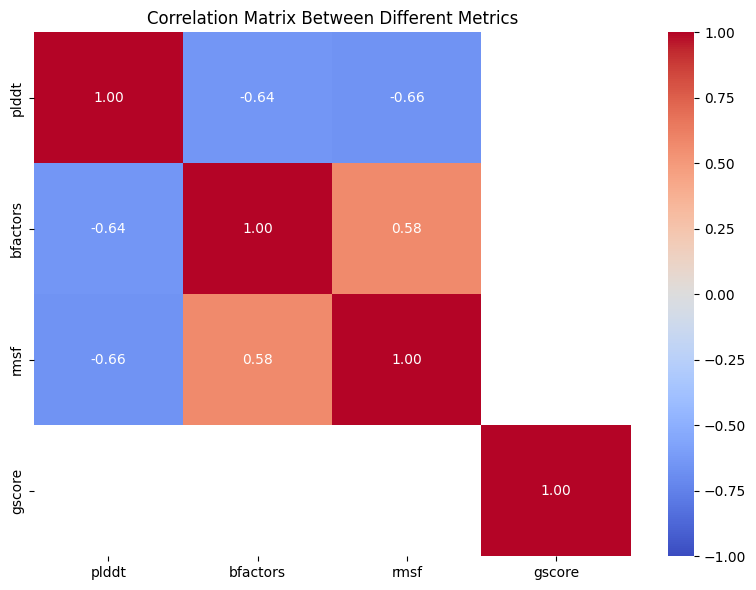

In [16]:

df_wide = pd.read_csv("/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/residue_level_wide_format.csv")
corr_matrix = df_wide[["plddt", "bfactors", "rmsf", "gscore"]].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix Between Different Metrics")
plt.tight_layout()
plt.savefig("/Users/gaoyiting/Bioinformatik/pp1/create_dataset/result/correlation_matrix.png", dpi=300, bbox_inches='tight')

In [6]:
print(df_wide["gscore"].isna().sum(), "/", len(df_wide))
print(df_wide.dropna(subset=["plddt", "gscore"]).shape[0])


24578962 / 24935575
0


In [8]:
from itertools import combinations

sources = ["plddt", "bfactors", "rmsf", "gscore"]
for s1, s2 in combinations(sources, 2):
    n = df_wide.dropna(subset=[s1, s2]).shape[0]
    print(f"{s1} ∩ {s2}: {n} residues with both values")


plddt ∩ bfactors: 429949 residues with both values
plddt ∩ rmsf: 429953 residues with both values
plddt ∩ gscore: 0 residues with both values
bfactors ∩ rmsf: 429949 residues with both values
bfactors ∩ gscore: 0 residues with both values
rmsf ∩ gscore: 0 residues with both values
